# Predicting Rainfall and Extreme Events in Bhutan

This notebook explores a data-driven approach to forecasting rainfall and detecting extreme rainfall events using historical meteorological data from Bhutan. The workflow integrates both regression and classification strategies, culminating in a hybrid model for improved prediction accuracy.

## 🔄 Workflow Overview

1. **Load Data**  
   Import and prepare the cleaned dataset with daily weather observations across Bhutan.

2. **Add Features for Predictive Modeling**  
   Engineer lag-based, rolling mean, and rolling std features for rainfall, temperature, and humidity.

3. **Split Training and Test Datasets**
   - 3.1 View training and testing data split based on a fixed cutoff date (`2015-10-01`).
   - 3.2 View list of predictive features used in model training.

4. **Establish XGBoost Regression to Predict Rainfall**
   - 4.1 Fit a baseline regression model on all available dates.
   - 4.2 Visualize feature importance to understand which variables drive rainfall prediction.

5. **Constrain on Heavy Rain Days for Regression**  
   Focus on modeling only days with heavy rainfall (e.g., ≥ 50mm) to improve forecasting under extreme conditions.

6. **Define a Classification Problem**  
   Reframe the problem as binary classification to identify whether a day will experience extreme rainfall.

7. **Apply SMOTE to Address Class Imbalance**  
   Use SMOTE to oversample rare extreme rainfall events and improve classification performance (notably recall and F1 score).

8. **A Hybrid Model**  
   Combine classification and regression:
   - First classify whether a day is extreme or not.
   - Then apply separate regressors for extreme and non-extreme days.
   - Evaluate performance using RMSE, R², classification report, confusion matrix, and error plots.

---

This notebook provides a scalable, interpretable framework for predicting both rainfall amount and extreme rainfall likelihood—key steps for improving early warning systems and climate resilience in Bhutan.


In [318]:
import os
import numpy as np
import pandas as pd

from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import time
import pickle

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_squared_error, r2_score, classification_report

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

## Load data

In [254]:
# Load the processed data
output_dir = '../processed_data'

# Load all region data from processed .pkl files
region_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]

region_data = {}
for file in region_files:
    region_name = file.replace('.pkl', '')
    df = pd.read_pickle(os.path.join(output_dir, file))
    region_data[region_name] = df

In [255]:
# use one region to get started
df = region_data['Zhemgang'].copy()
df.info()

# Drop rows with missing rainfall
df = df.dropna(subset=['Rainfall'])

# Ensure Date is datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Optional: sort index in case it's not sorted
df = df.sort_index()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9283 entries, 0 to 9282
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Year      9283 non-null   int64         
 1   Month     9283 non-null   int64         
 2   Day       9283 non-null   int64         
 3   Rainfall  9272 non-null   float64       
 4   Tmax      9282 non-null   float64       
 5   Tmin      9283 non-null   float64       
 6   RH        9190 non-null   float64       
 7   Date      9283 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 580.3 KB


,Year,Month,Day,Rainfall,Tmax,Tmin,RH
Date,,,,,,,
2000-01-01,2000,1,1,0.0,14.0,4.0,56.0
2000-01-02,2000,1,2,0.0,14.0,5.0,42.0
2000-01-03,2000,1,3,0.0,15.0,5.0,67.0
2000-01-04,2000,1,4,0.0,15.0,5.0,45.0
2000-01-05,2000,1,5,0.0,15.0,5.0,58.0


## Add features for predictive modeling

In [280]:
def create_features_with_weather(df,
                                  target_col='Rainfall',
                                  lag_days=[1, 2, 3, 7, 14, 30],
                                  rolling_windows=[3, 7, 14, 30],
                                  weather_cols=['RH', 'Tmax', 'Tmin'],
                                  add_dayofyear=True,
                                  add_monsoon_flag=True):
    """
    Create lag and rolling features for Rainfall and weather variables.
    Optionally includes:
    - dayofyear and its cyclic encoding
    - summer monsoon binary indicator (June–September)
    """
    df = df.copy()

    # --- Time features ---
    if add_dayofyear:
        df['dayofyear'] = df.index.dayofyear

    if add_monsoon_flag:
        df['is_monsoon'] = df.index.month.isin([6, 7, 8, 9]).astype(int)

    # --- Lag + rolling for Rainfall ---
    for lag in lag_days:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)

    for win in rolling_windows:
        df[f'{target_col}_rolling_mean_{win}'] = df[target_col].rolling(win).mean()
        df[f'{target_col}_rolling_std_{win}'] = df[target_col].rolling(win).std()

    # --- Lag + rolling for weather variables ---
    for col in weather_cols:
        for lag in lag_days:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
        for win in rolling_windows:
            df[f'{col}_rolling_mean_{win}'] = df[col].rolling(win).mean()
            df[f'{col}_rolling_std_{win}'] = df[col].rolling(win).std()

    return df


In [258]:
df_feat = create_features_with_weather(df)
df_feat = df_feat.dropna()
df_feat.head()

,Year,Month,Day,Rainfall,Tmax,Tmin,RH,dayofyear,is_monsoon,Rainfall_lag1,...,Tmin_lag14,Tmin_lag30,Tmin_rolling_mean_3,Tmin_rolling_std_3,Tmin_rolling_mean_7,Tmin_rolling_std_7,Tmin_rolling_mean_14,Tmin_rolling_std_14,Tmin_rolling_mean_30,Tmin_rolling_std_30
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,2000,1,31,0.0,11.0,3.0,76.0,31,0,0.0,...,5.0,4.0,3.333333,1.527525,3.857143,1.069045,4.142857,1.027105,4.200000,0.915386
2000-02-01,2000,2,1,0.0,11.0,3.5,56.0,32,0,0.0,...,4.0,5.0,2.833333,0.763763,3.785714,1.074598,4.107143,1.041053,4.150000,0.911138
2000-02-02,2000,2,2,5.8,10.0,4.0,52.0,33,0,0.0,...,5.0,5.0,3.500000,0.500000,3.785714,1.074598,4.035714,1.008889,4.116667,0.897154
2000-02-03,2000,2,3,11.8,5.0,2.0,52.0,34,0,5.8,...,6.0,5.0,3.166667,1.040833,3.500000,1.258306,3.750000,0.975665,4.016667,0.960274
2000-02-04,2000,2,4,0.0,10.0,5.0,76.0,35,0,11.8,...,4.0,5.0,3.666667,1.527525,3.500000,1.258306,3.821429,1.030443,4.016667,0.960274


## Split training and test datasets

In [281]:
def split_and_report_shapes(df_feat, date_split="2015-10-01", drop_cols=['Rainfall', 'Tmax', 'Tmin', 'RH']):
    """
    Splits df_feat into training and test sets by date, and prints shapes of X and y.

    Parameters:
        df_feat (pd.DataFrame): Full dataset with features and targets.
        date_split (str): Date string to split training and test sets.
        drop_cols (list): Columns to exclude from features.

    Returns:
        X_train, y_train, X_test, y_test
    """
    train = df_feat[df_feat.index < date_split]
    test = df_feat[df_feat.index >= date_split]

    features = [col for col in df_feat.columns if col not in drop_cols]

    X_train = train[features]
    y_train = train['Rainfall']
    X_test = test[features]
    y_test = test['Rainfall']

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape:  {X_test.shape}")
    print(f"y_test shape:  {y_test.shape}")

    return X_train, y_train, X_test, y_test


In [282]:
X_train, y_train, X_test, y_test = split_and_report_shapes(df_feat)

X_train shape: (5622, 61)
y_train shape: (5622,)
X_test shape:  (3327, 61)
y_test shape:  (3327,)


### View training and testing data

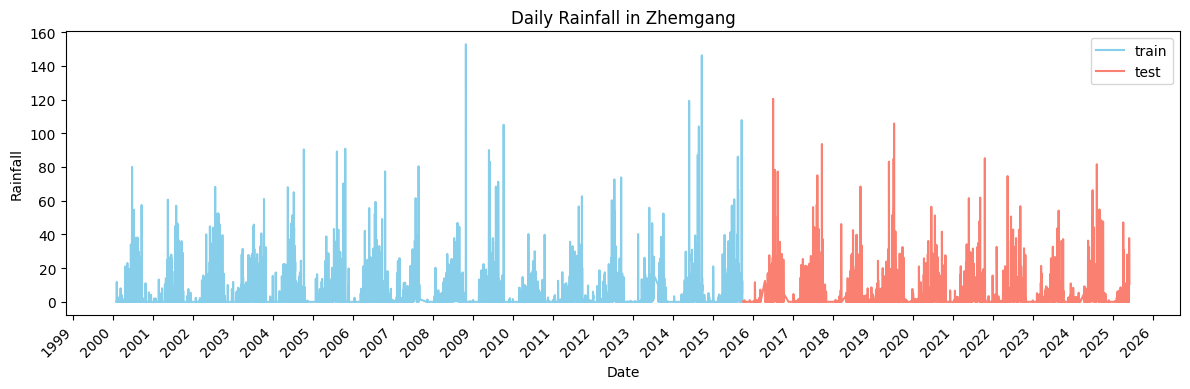

In [283]:
# Plot
fig, ax = plt.subplots(figsize=(12, 4))
y_train.plot(ax=ax, label='train', color='skyblue')
y_test.plot(ax=ax, label='test', color='salmon')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_xlabel('Date')
ax.set_ylabel('Rainfall')
ax.set_title('Daily Rainfall in Zhemgang')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

### View list of features

In [284]:
print("\n".join(X_train.columns.tolist()))

Year
Month
Day
dayofyear
is_monsoon
Rainfall_lag1
Rainfall_lag2
Rainfall_lag3
Rainfall_lag7
Rainfall_lag14
Rainfall_lag30
Rainfall_rolling_mean_3
Rainfall_rolling_std_3
Rainfall_rolling_mean_7
Rainfall_rolling_std_7
Rainfall_rolling_mean_14
Rainfall_rolling_std_14
Rainfall_rolling_mean_30
Rainfall_rolling_std_30
RH_lag1
RH_lag2
RH_lag3
RH_lag7
RH_lag14
RH_lag30
RH_rolling_mean_3
RH_rolling_std_3
RH_rolling_mean_7
RH_rolling_std_7
RH_rolling_mean_14
RH_rolling_std_14
RH_rolling_mean_30
RH_rolling_std_30
Tmax_lag1
Tmax_lag2
Tmax_lag3
Tmax_lag7
Tmax_lag14
Tmax_lag30
Tmax_rolling_mean_3
Tmax_rolling_std_3
Tmax_rolling_mean_7
Tmax_rolling_std_7
Tmax_rolling_mean_14
Tmax_rolling_std_14
Tmax_rolling_mean_30
Tmax_rolling_std_30
Tmin_lag1
Tmin_lag2
Tmin_lag3
Tmin_lag7
Tmin_lag14
Tmin_lag30
Tmin_rolling_mean_3
Tmin_rolling_std_3
Tmin_rolling_mean_7
Tmin_rolling_std_7
Tmin_rolling_mean_14
Tmin_rolling_std_14
Tmin_rolling_mean_30
Tmin_rolling_std_30


## Establish XGBoost regression to predict rainfall

In [262]:
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [263]:
# Predict on training set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
print(f"RMSE on training set: {train_rmse:.2f}")

rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"RMSE on test set: {rmse:.2f}")


RMSE on training set: 1.44
RMSE on test set: 2.59


### Examine model fit

In [264]:
def plot_forecast_and_errors(y_true, y_pred, title_prefix="Test"):
    """
    Plots actual vs predicted and error over time (with top 20 largest errors annotated).

    Parameters:
        y_true (pd.Series): Actual values with datetime index.
        y_pred (array-like): Predicted values (same order as y_true).
        title_prefix (str): Title prefix to distinguish train/test.
    """
    errors = y_true - y_pred
    abs_errors = errors.abs()
    top20 = abs_errors.sort_values(ascending=False).head(20)

    fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # --- Top subplot: Actual vs Predicted ---
    axs[0].plot(y_true.index, y_true, label='Actual')
    axs[0].plot(y_true.index, y_pred, label='Predicted', color='orange')
    axs[0].set_title(f"{title_prefix} Set: XGBoost Rainfall Forecast")
    axs[0].set_ylabel("Rainfall")
    axs[0].legend()
    axs[0].grid(True)

    # --- Bottom subplot: Prediction Error + Top 20 Annotation ---
    axs[1].plot(errors.index, errors, label="Prediction Error", color='blue')
    axs[1].axhline(0, color='black', linestyle='--')
    axs[1].set_title("Prediction Error Over Time (Top 20 Annotated)")
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Error (Actual − Predicted)")
    axs[1].grid(True)

    for i, (date, err) in enumerate(top20.items()):
        actual_error = errors.loc[date]
        axs[1].annotate(
            date.strftime('%Y-%m-%d'),
            xy=(date, actual_error),
            xytext=(date, actual_error + np.sign(actual_error)*10),
            arrowprops=dict(facecolor='red', arrowstyle='->', lw=1),
            fontsize=8,
            color='red',
            ha='center'
        )

    plt.tight_layout()
    plt.show()


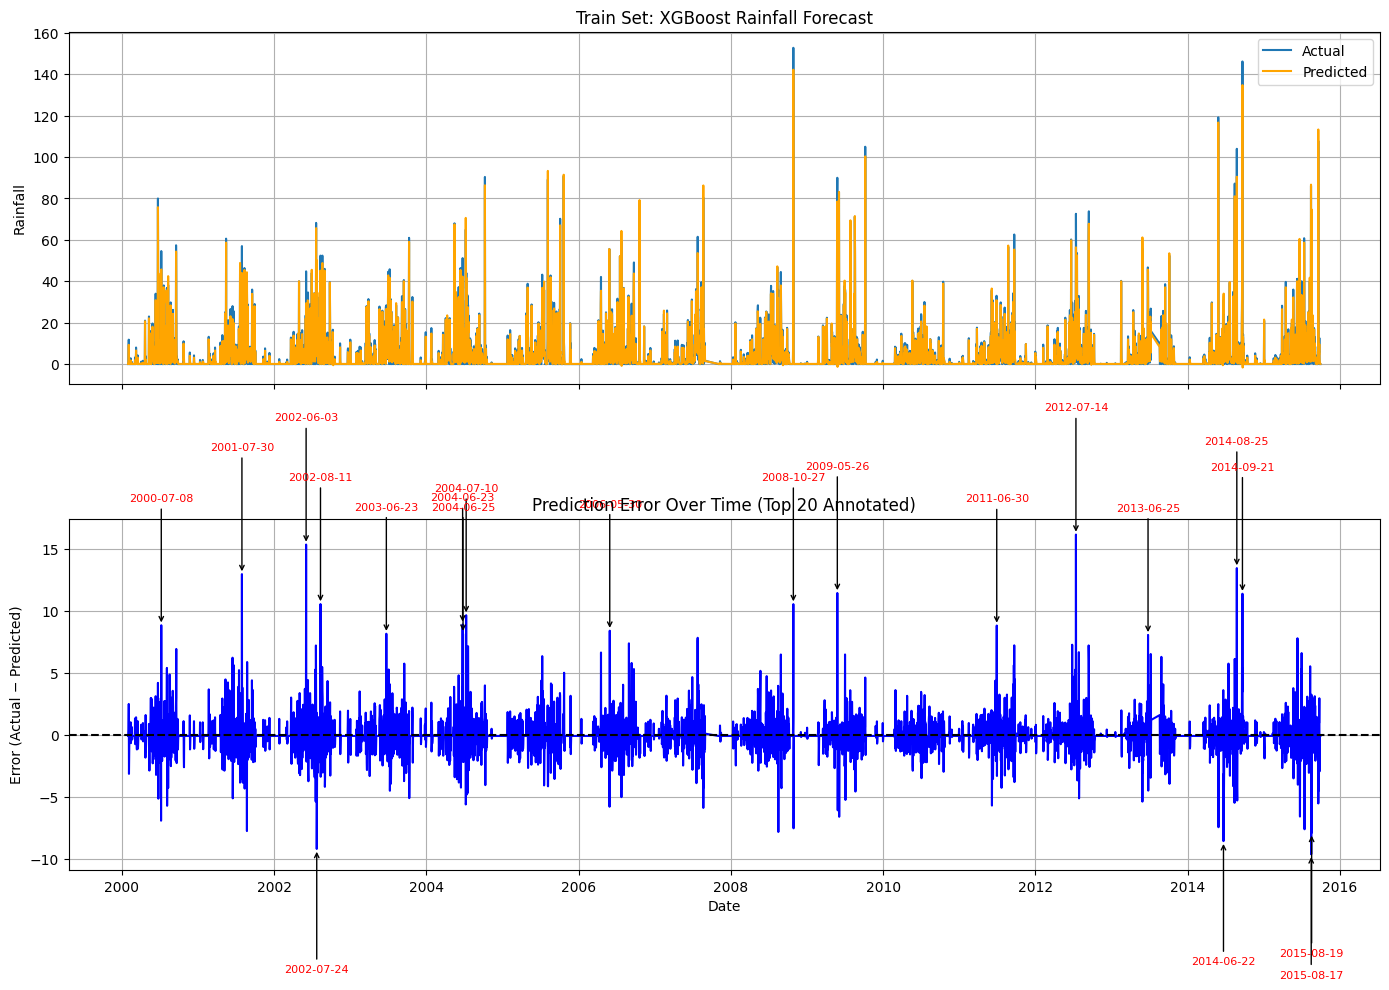

In [265]:
plot_forecast_and_errors(y_train, y_train_pred, title_prefix="Train")

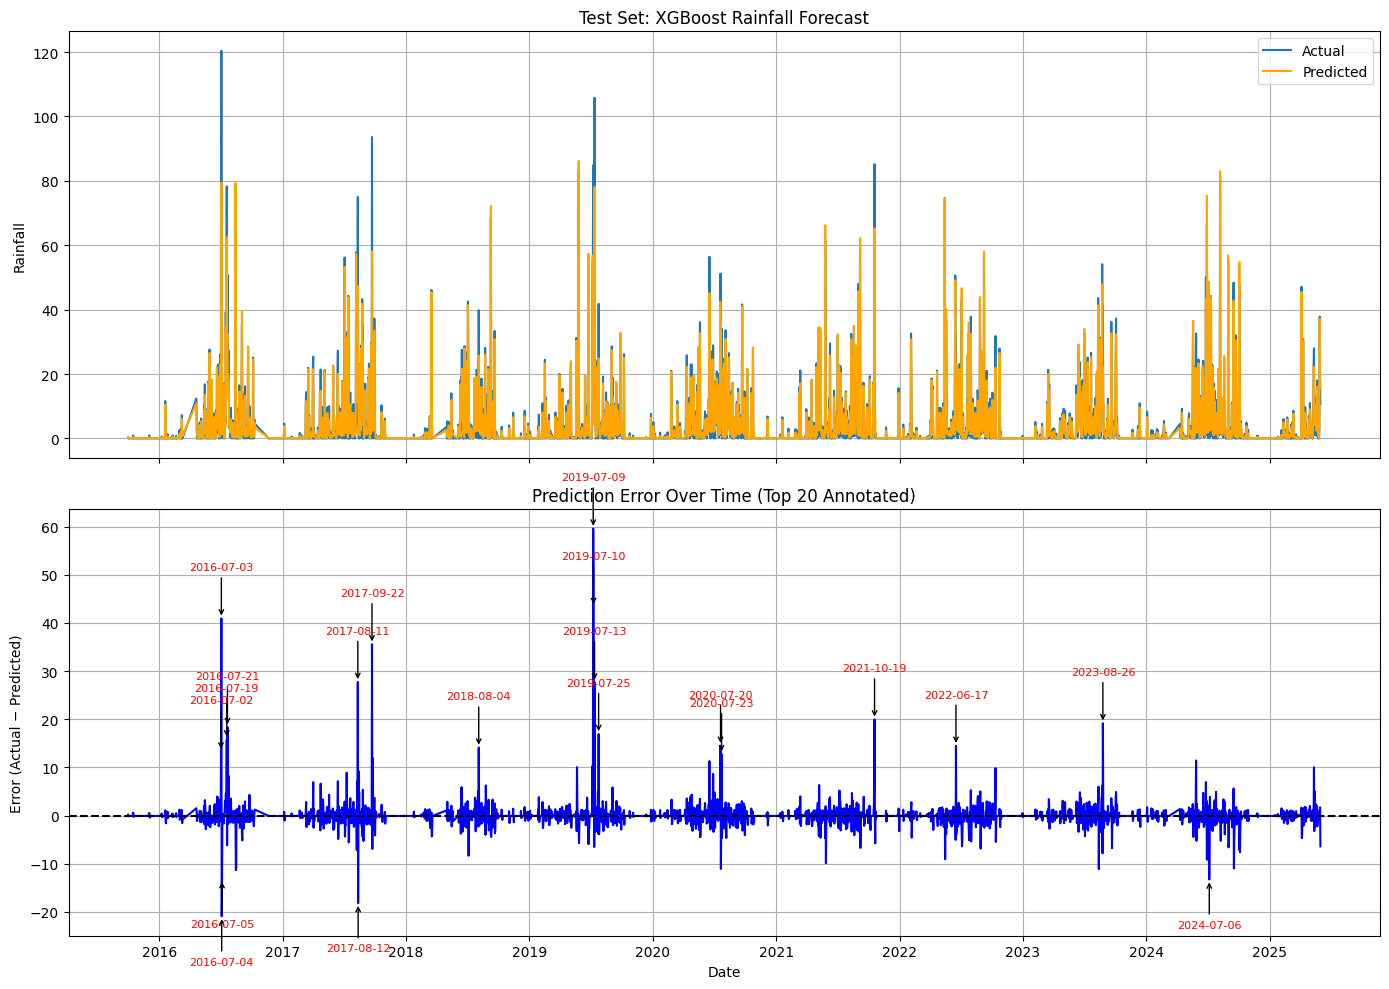

In [266]:
plot_forecast_and_errors(y_test, y_test_pred, title_prefix="Test")

### Check XGBoost feature importance

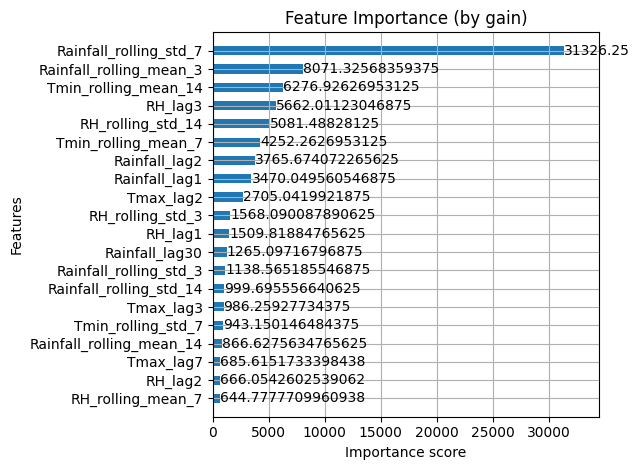

In [267]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain', height=0.5)
plt.title("Feature Importance (by gain)")
plt.tight_layout()
plt.show()

In [268]:
# Get feature importance as a dictionary
importance_dict = model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame(
    importance_dict.items(), columns=["Feature", "Gain"]
).sort_values(by="Gain", ascending=False)

# Display top 20
top_20 = importance_df.head(20)
print(top_20)


                     Feature          Gain
12    Rainfall_rolling_std_7  31326.250000
9    Rainfall_rolling_mean_3   8071.325684
45      Tmin_rolling_mean_14   6276.926270
19                   RH_lag3   5662.011230
27         RH_rolling_std_14   5081.488281
43       Tmin_rolling_mean_7   4252.262695
4              Rainfall_lag2   3765.674072
3              Rainfall_lag1   3470.049561
31                 Tmax_lag2   2705.041992
24          RH_rolling_std_3   1568.090088
17                   RH_lag1   1509.818848
8             Rainfall_lag30   1265.097168
10    Rainfall_rolling_std_3   1138.565186
14   Rainfall_rolling_std_14    999.695557
32                 Tmax_lag3    986.259277
44        Tmin_rolling_std_7    943.150146
13  Rainfall_rolling_mean_14    866.627563
33                 Tmax_lag7    685.615173
18                   RH_lag2    666.054260
25         RH_rolling_mean_7    644.777771


## Constrain on heavy rain days for regression

In [285]:
# Define threshold of heavy rain
threshold = 50

# Keep only heavy rain days
df_heavy = df_feat[df_feat['Rainfall'] >= threshold].copy()

X_train, y_train, X_test, y_test = split_and_report_shapes(df_heavy)

X_train shape: (50, 61)
y_train shape: (50,)
X_test shape:  (30, 61)
y_test shape:  (30,)


In [286]:
model_heavy = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

model_heavy.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [287]:
# Predict on training set
y_train_pred = model_heavy.predict(X_train)
y_test_pred = model_heavy.predict(X_test)

# Calculate RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
print(f"RMSE on training set: {train_rmse:.2f}")

rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"RMSE on test set: {rmse:.2f}")

RMSE on training set: 0.16
RMSE on test set: 7.41


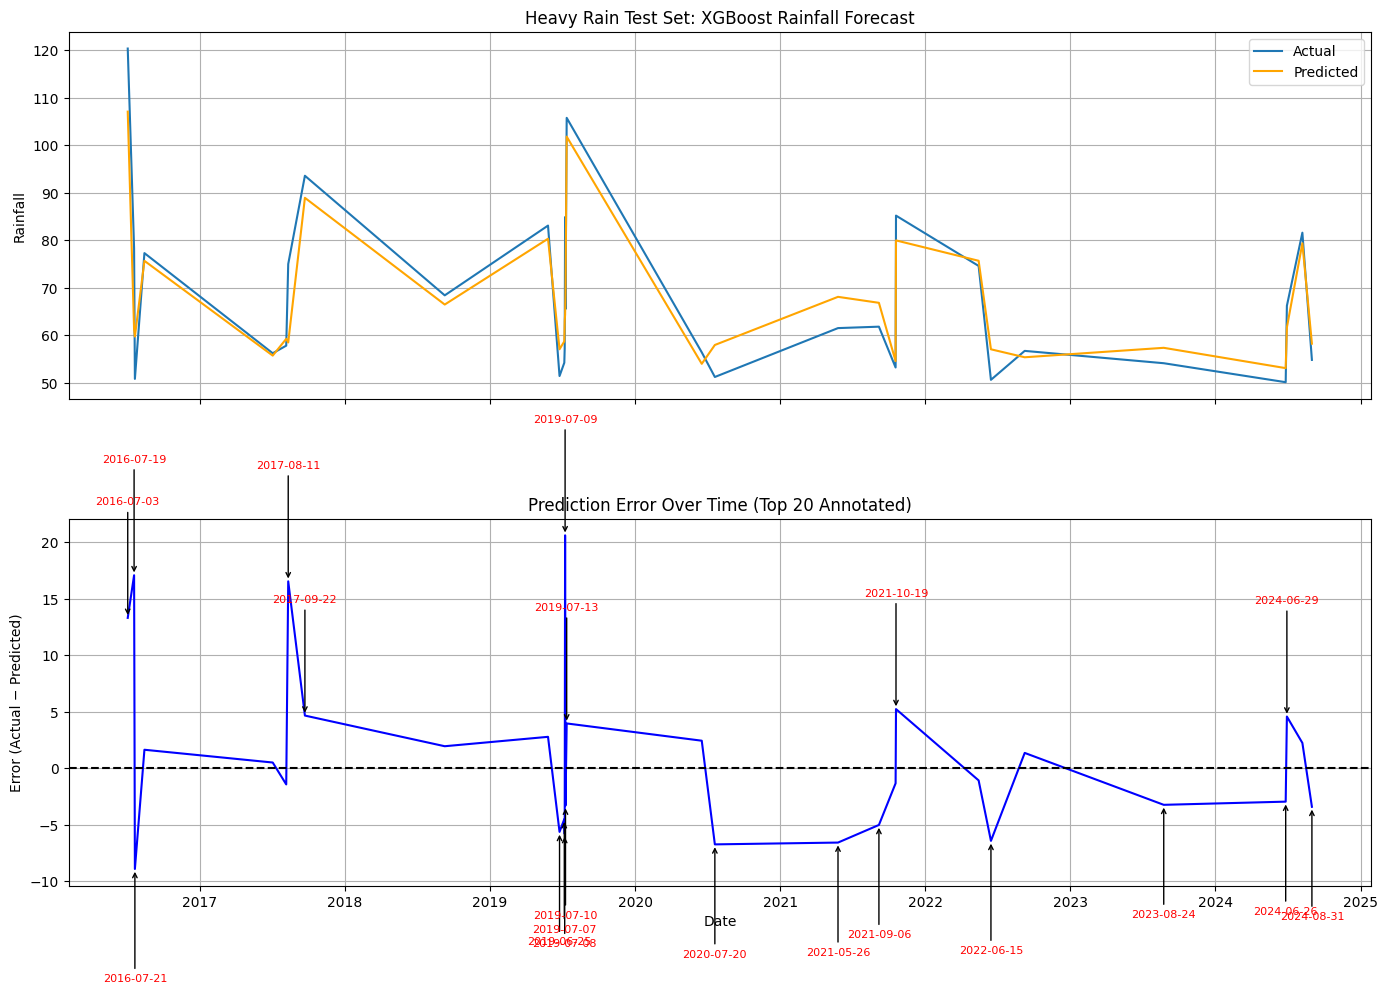

In [288]:
plot_forecast_and_errors(y_test, y_test_pred, title_prefix="Heavy Rain Test")

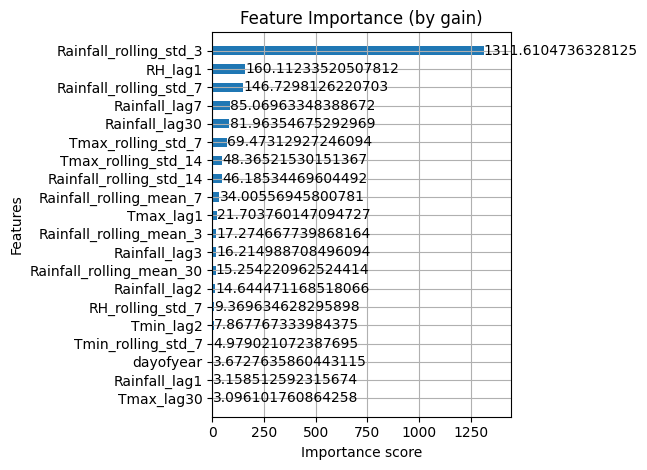

In [289]:
xgb.plot_importance(model_heavy, max_num_features=20, importance_type='gain', height=0.5)
plt.title("Feature Importance (by gain)")
plt.tight_layout()
plt.show()

## Define a classification problem

In [290]:
# Define heavy rain threshold
threshold = 50  # in mm

# Create binary target variable: 1 = heavy rain, 0 = not heavy
df_class = df_feat.copy()
df_class['HeavyRain'] = (df_class['Rainfall'] >= threshold).astype(int)

# Split train/test
train = df_class[df_class.index < "2015-10-01"]
test = df_class[df_class.index >= "2015-10-01"]

# Drop current-day weather variables and original Rainfall
drop_cols = ['Rainfall', 'Tmax', 'Tmin', 'RH']
features = [col for col in df_class.columns if col not in drop_cols + ['HeavyRain']]

# Prepare features and target
X_train = train[features]
y_train = train['HeavyRain']
X_test = test[features]
y_test = test['HeavyRain']

print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")
print(f"Heavy rain proportion (train): {y_train.mean():.3f}, (test): {y_test.mean():.3f}")


Training samples: 5622, Features: 61
Heavy rain proportion (train): 0.009, (test): 0.009


In [295]:
model_class = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model_class.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:40:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

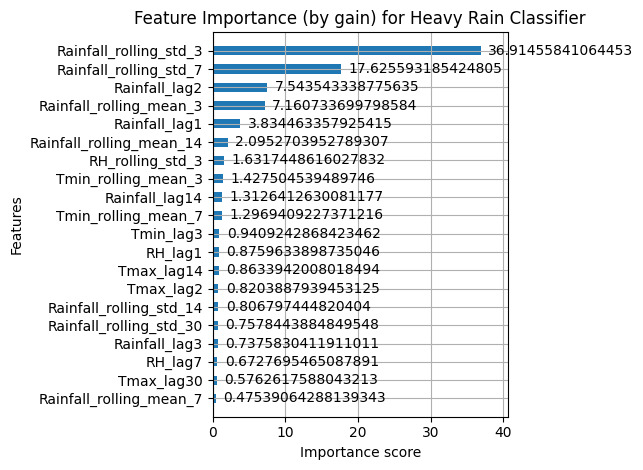

In [296]:
# Plot top 20 features by gain
xgb.plot_importance(model_class, 
                    max_num_features=20, 
                    importance_type='gain', 
                    height=0.5)

plt.title("Feature Importance (by gain) for Heavy Rain Classifier")
plt.tight_layout()
plt.show()


In [297]:
# Get predicted probabilities and class labels
y_proba = model.predict_proba(X_test)[:, 1]  # Probability for class 1 (heavy rain)
y_pred = model.predict(X_test)              # Predicted class labels

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Display results
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"AUC-ROC:   {auc:.3f}")


Accuracy:  0.996
Precision: 0.950
Recall:    0.633
F1 Score:  0.760
AUC-ROC:   0.998



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3334
           1       0.95      0.63      0.76        30

    accuracy                           1.00      3364
   macro avg       0.97      0.82      0.88      3364
weighted avg       1.00      1.00      1.00      3364



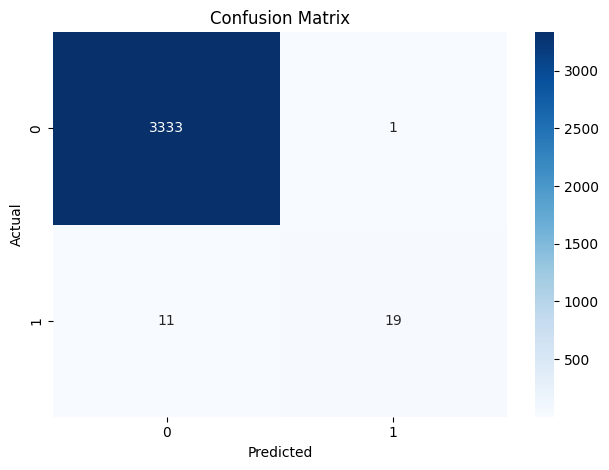

In [224]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Apply SMOTE to address imbalance

In [303]:
# Step 1: Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {X_train.shape}, Class balance: {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {X_train_bal.shape}, Class balance: {pd.Series(y_train_bal).value_counts().to_dict()}")

# Step 2: Train XGBoost model
model_smote = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model_smote.fit(X_train_bal, y_train_bal)

Before SMOTE: (5622, 61), Class balance: {0: 5572, 1: 50}
After SMOTE: (11144, 61), Class balance: {0: 5572, 1: 5572}


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3297
           1       0.67      0.80      0.73        30

    accuracy                           0.99      3327
   macro avg       0.83      0.90      0.86      3327
weighted avg       1.00      0.99      0.99      3327

AUC-ROC: 0.998


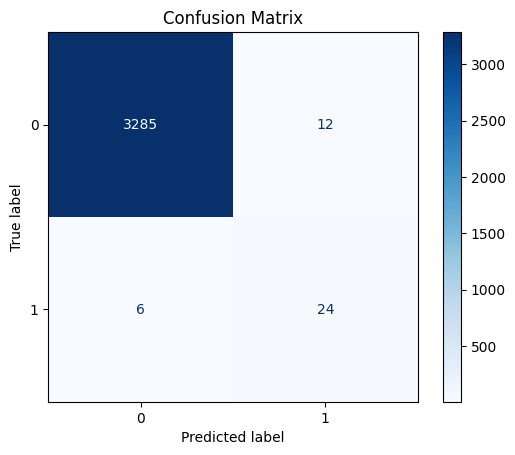

In [304]:
# Step 3: Predict and evaluate
y_pred = model_smote.predict(X_test)
y_proba = model_smote.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {auc_score:.3f}")

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

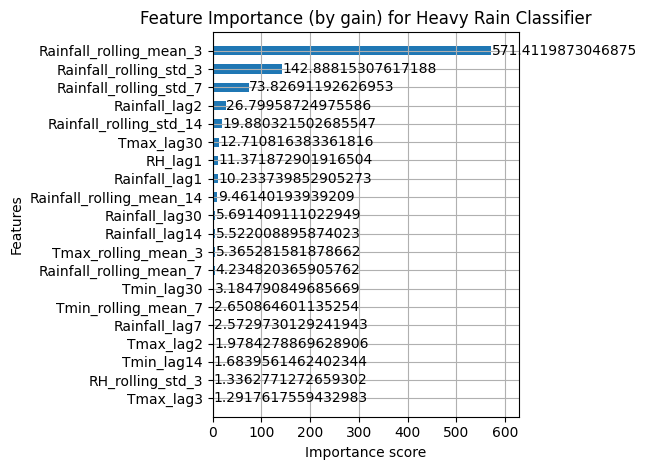

In [305]:
# Plot top 20 features by gain
xgb.plot_importance(model_smote, 
                    max_num_features=20, 
                    importance_type='gain', 
                    height=0.5)

plt.title("Feature Importance (by gain) for Heavy Rain Classifier")
plt.tight_layout()
plt.show()


In [306]:
# y_test: true labels (Pandas Series with DateTime index)
# y_pred: predicted labels (from model)

# Make sure your y_test has a datetime index
assert isinstance(y_test.index, pd.DatetimeIndex)

# Find misclassified indices
false_negatives = (y_test == 1) & (y_pred == 0)  # missed heavy rain
false_positives = (y_test == 0) & (y_pred == 1)  # wrongly predicted heavy rain

# Extract the corresponding dates
fn_dates = y_test[false_negatives].index
fp_dates = y_test[false_positives].index

print("❌ False Negatives (Missed Heavy Rain):")
print(fn_dates)

print("\n⚠️ False Positives (Wrongly Predicted Heavy Rain):")
print(fp_dates)


❌ False Negatives (Missed Heavy Rain):
DatetimeIndex(['2016-07-21', '2017-08-11', '2019-07-08', '2019-07-09',
               '2019-07-10', '2022-06-15'],
              dtype='datetime64[ns]', name='Date', freq=None)

⚠️ False Positives (Wrongly Predicted Heavy Rain):
DatetimeIndex(['2016-07-04', '2016-07-22', '2016-07-23', '2016-07-24',
               '2017-08-12', '2019-07-14', '2020-07-23', '2021-05-27',
               '2024-06-27', '2024-07-05', '2024-09-16', '2024-10-03'],
              dtype='datetime64[ns]', name='Date', freq=None)


## A hybrid model

In [320]:
df = df_feat.copy()
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df['is_extreme'] = (df['Rainfall'] >= 50).astype(int)

exclude_cols = ['Rainfall', 'is_extreme']
feature_cols = [col for col in df.columns if col not in exclude_cols]


In [321]:
train = df[df.index < "2015-10-01"]
test = df[df.index >= "2015-10-01"]

X_train = train[feature_cols]
y_train_reg = train['Rainfall']
y_train_bin = train['is_extreme']

X_test = test[feature_cols]
y_test_reg = test['Rainfall']
y_test_bin = test['is_extreme']


In [322]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bin_bal = smote.fit_resample(X_train, y_train_bin)

clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train_bal, y_train_bin_bal)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:57:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [323]:
reg_extreme = XGBRegressor(random_state=42)
reg_extreme.fit(X_train[y_train_bin == 1], y_train_reg[y_train_bin == 1])

reg_non_extreme = XGBRegressor(random_state=42)
reg_non_extreme.fit(X_train[y_train_bin == 0], y_train_reg[y_train_bin == 0])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [324]:
y_pred_bin_test = clf.predict(X_test)
y_pred_hybrid_test = [
    reg_extreme.predict(X_test.iloc[[i]])[0] if y_pred_bin_test[i] == 1
    else reg_non_extreme.predict(X_test.iloc[[i]])[0]
    for i in range(len(X_test))
]


In [325]:
y_pred_bin_train = clf.predict(X_train)
y_pred_hybrid_train = [
    reg_extreme.predict(X_train.iloc[[i]])[0] if y_pred_bin_train[i] == 1
    else reg_non_extreme.predict(X_train.iloc[[i]])[0]
    for i in range(len(X_train))
]


In [331]:
# Print test set classification report
print("=== Classification Report: TEST SET ===")
print(classification_report(y_test_bin, y_pred_bin_test))

# Print train set classification report
print("\n=== Classification Report: TRAIN SET ===")
print(classification_report(y_train_bin, y_pred_bin_train))


=== Classification Report: TEST SET ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3297
           1       0.80      0.80      0.80        30

    accuracy                           1.00      3327
   macro avg       0.90      0.90      0.90      3327
weighted avg       1.00      1.00      1.00      3327


=== Classification Report: TRAIN SET ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5572
           1       1.00      1.00      1.00        50

    accuracy                           1.00      5622
   macro avg       1.00      1.00      1.00      5622
weighted avg       1.00      1.00      1.00      5622



In [332]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for test set
rmse_test = np.sqrt(mean_squared_error(y_test_reg, y_pred_hybrid_test))
print(f"Test RMSE: {rmse_test:.3f}")

# Calculate RMSE for train set
rmse_train = np.sqrt(mean_squared_error(y_train_reg, y_pred_hybrid_train))
print(f"Train RMSE: {rmse_train:.3f}")


Test RMSE: 3.231
Train RMSE: 0.070


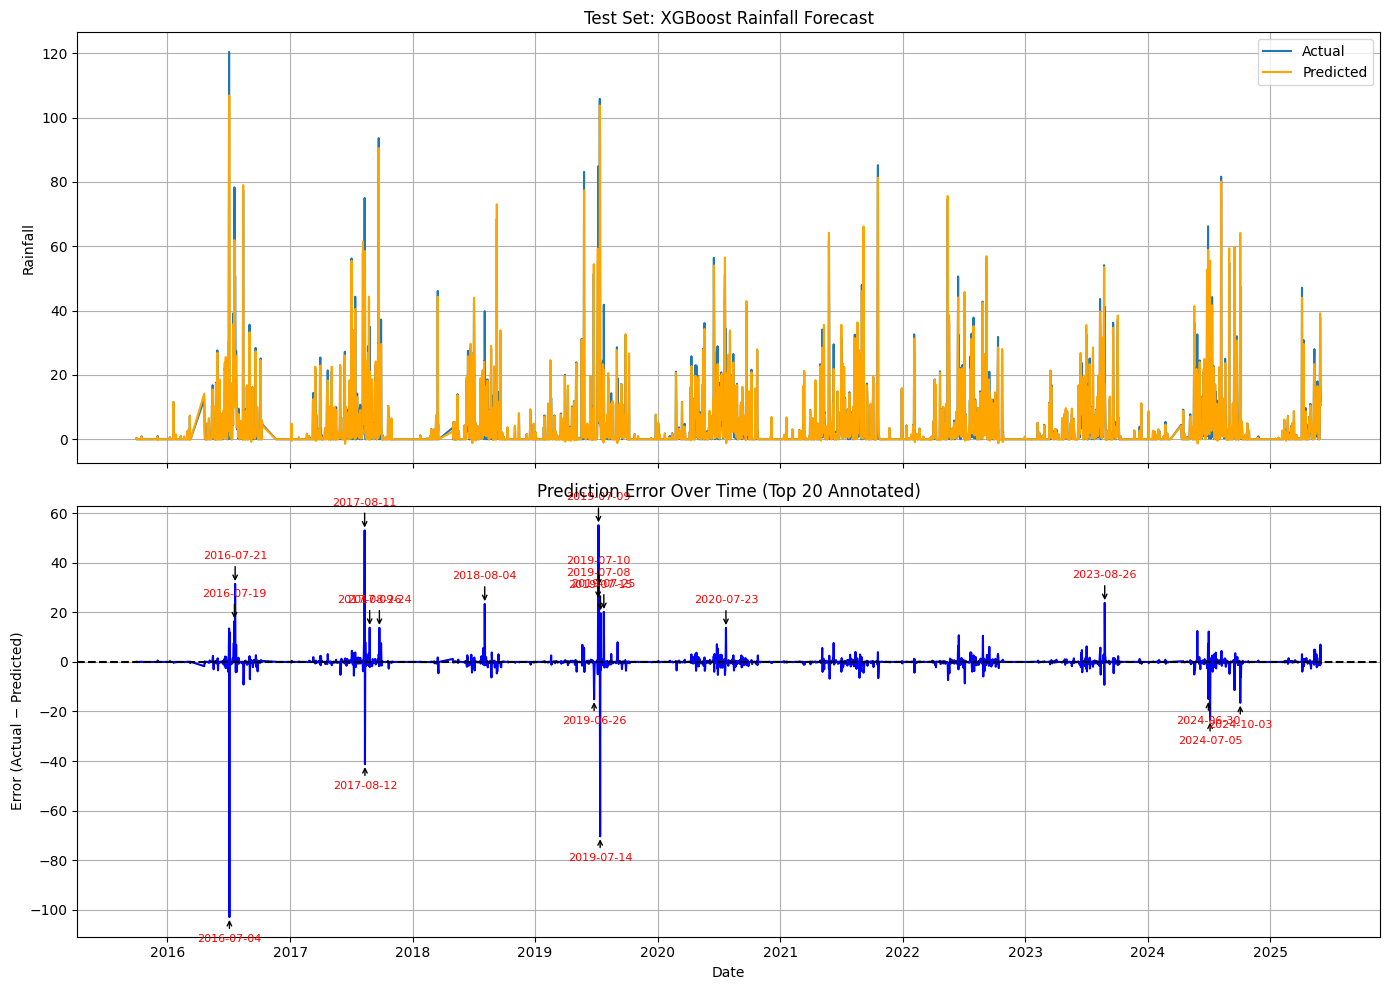

In [334]:
plot_forecast_and_errors(y_test_reg, y_pred_hybrid_test)

<Figure size 600x500 with 0 Axes>

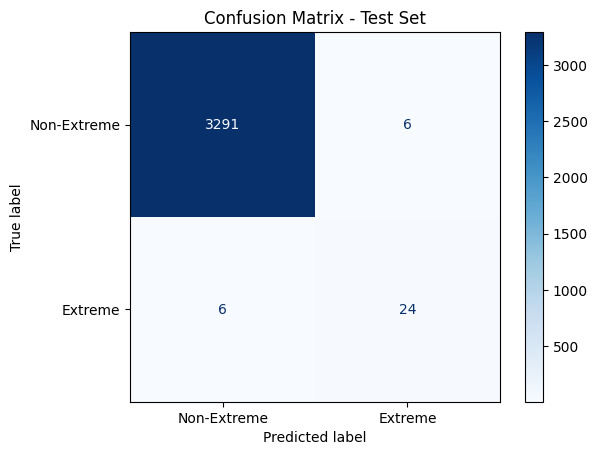

In [335]:
# Compute confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Extreme", "Extreme"])

# Plot
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.grid(False)
plt.show()